## Generator in DC GAN
##### Our approach is to modify CNN by making these changes
- We observed that, The first is the all convolutional net (Springenberg et al., 2014) which replaces deterministic spatial
pooling functions (such as maxpooling) with strided convolutions, allowing the network to learn
its own spatial downsampling.

- So we use downsampling to allow generator to learn it's own spatial upsampling.

- The second change is eliminating FULLY CONNECTED LAYERS on top of the convolutional features.
  Ex: Global image pooling which is utilized in state-of-the-art image classification models

### Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.


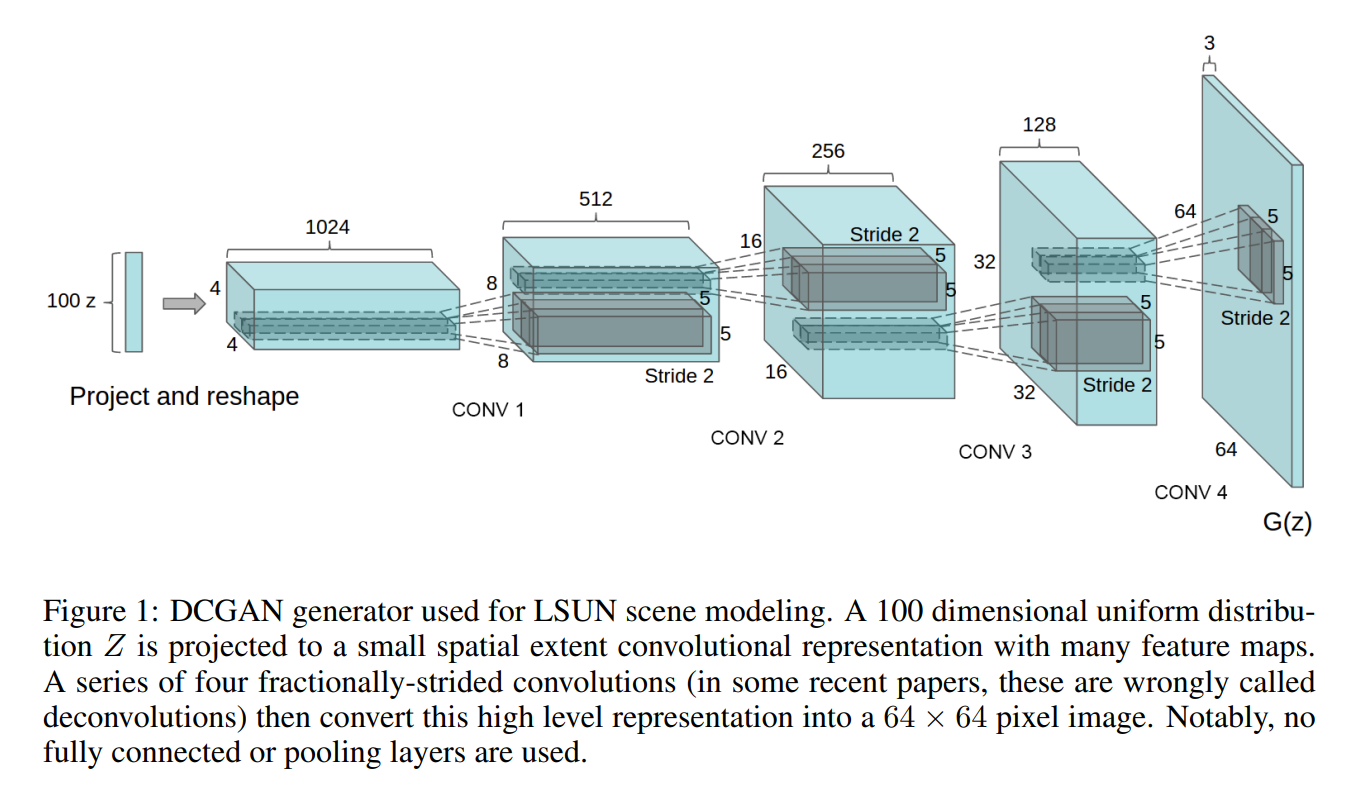


suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped
stabilize training.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader

random_noise = 128

In [2]:
class Generator(nn.Module):
    def __init__(self):
        """Output should be an image of 28x28x1 (WxHxC)"""
        super(Generator,self).__init__()
        # a fully connected network to project noise vector to 7*7*128
        self.fc = nn.Sequential(
            nn.Linear(random_noise,7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(True)
        )
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,1,4,2,1),
            nn.Tanh()
        )

    def forward(self,z):
        x = self.fc(z)
        x = x.view(-1,128,7,7)
        return self.gen(x)

## Discriminator in DCGAN

In [14]:
class Discriminator(nn.Module):
    """
        Input of the Discriminator is an image should be 1x28x28 (CxWxH)
        The output is a single neuron with sigmoid
        Downsampling an image 28x28x1 to 1
    """
    def __init__(self):
        super(Discriminator,self).__init__()
        """
            The output channels represent feature maps of an image in the following networks
        """
        self.model = nn.Sequential(
            #input of image 28x28x1 -> 14x14x64
            nn.Conv2d(in_channels=1,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*256,1),
            nn.Sigmoid()
        )
    def forward(self,z):
        x = self.model(z)
        return self.fc(x)

In [15]:
gen = Generator()
disc = Discriminator()

In [16]:
device = 'cpu'

In [17]:
if torch.cuda.is_available():
    device = 'cuda'

In [18]:
n_epochs = 100
batch_size = 64
lr = 2e-4
b1=0.5
b2=0.999

In [19]:
adverserial_loss = nn.BCELoss()

In [20]:
import torch.optim as optim
opt_gen = optim.Adam(gen.parameters(),lr= lr,betas=(b1,b2))
opt_disc = optim.Adam(disc.parameters(),lr= lr,betas=(b1,b2))

# Preparing the MNIST data

In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = MNIST(root='./mnist_data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [22]:
gen.to(device)
disc.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [23]:
# Training loop
for epoch in range(n_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to('cuda')
        current_batch_size = real_images.size(0)
        
        # Real and fake labels
        real_labels = torch.ones(current_batch_size, 1).to('cuda')
        fake_labels = torch.zeros(current_batch_size, 1).to('cuda')
        
        # Train Discriminator
        opt_disc.zero_grad()
        
        z = torch.randn(current_batch_size, random_noise).to('cuda')
        fake_images = gen(z)
        
        D_real = disc(real_images)
        D_fake = disc(fake_images.detach())
        
        real_loss = adverserial_loss(D_real, real_labels)
        fake_loss = adverserial_loss(D_fake, fake_labels)
        
        D_loss = real_loss + fake_loss
        D_loss.backward()
        opt_disc.step()
        
        # Train Generator
        opt_gen.zero_grad()
        
        z = torch.randn(current_batch_size, random_noise).to('cuda')
        fake_images = gen(z)
        D_fake = disc(fake_images)
        
        G_loss = adverserial_loss(D_fake, real_labels)
        G_loss.backward()
        opt_gen.step()
    
    print(f"Epoch [{epoch+1}/{n_epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

Epoch [1/100] | D Loss: 0.0220 | G Loss: 5.7718
Epoch [2/100] | D Loss: 0.1041 | G Loss: 3.3621
Epoch [3/100] | D Loss: 0.0387 | G Loss: 5.0973
Epoch [4/100] | D Loss: 0.0477 | G Loss: 5.0227
Epoch [5/100] | D Loss: 100.0000 | G Loss: 0.0000
Epoch [6/100] | D Loss: 0.0034 | G Loss: 9.5333
Epoch [7/100] | D Loss: 0.0740 | G Loss: 4.8818
Epoch [8/100] | D Loss: 0.0033 | G Loss: 8.5879
Epoch [9/100] | D Loss: 0.0059 | G Loss: 7.9542
Epoch [10/100] | D Loss: 0.0011 | G Loss: 7.6987
Epoch [11/100] | D Loss: 0.4202 | G Loss: 4.1123
Epoch [12/100] | D Loss: 0.0070 | G Loss: 7.0331
Epoch [13/100] | D Loss: 0.1413 | G Loss: 3.2176
Epoch [14/100] | D Loss: 0.0069 | G Loss: 9.7169
Epoch [15/100] | D Loss: 0.0111 | G Loss: 7.3030
Epoch [16/100] | D Loss: 0.0025 | G Loss: 11.1588
Epoch [17/100] | D Loss: 0.0011 | G Loss: 8.0836
Epoch [18/100] | D Loss: 0.0362 | G Loss: 5.2145
Epoch [19/100] | D Loss: 0.0698 | G Loss: 3.7830
Epoch [20/100] | D Loss: 0.0004 | G Loss: 7.2536
Epoch [21/100] | D Loss: 0

In [25]:
torch.save(disc.state_dict(),'./GAN weights/DCGANdisc.pt')
torch.save(gen.state_dict(),'./GAN weights/DCGANgen.pt')
